In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 128
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
76157,"[醫, 師, ：, 他, 有, 在, 騎, 腳, 踏, 車]","[O, O, O, O, O, O, O, O, O, O]"
76158,"[民, 眾, ：, 恩]","[O, O, O, O]"
76159,"[醫, 師, ：, 騎, 腳, 踏, 車, 可, 以]","[O, O, O, O, O, O, O, O, O]"
76160,"[小, 美]","[B-name, I-name]"


In [10]:
df['x'] = df['x'].apply(lambda row : str(row))
df['y'] = df['y'].apply(lambda row : str(row))
df = df.drop_duplicates()
df['x'] = df['x'].apply(lambda row : eval(row))
df['y'] = df['y'].apply(lambda row : eval(row))
df

/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
75713,"[醫, 師, ：, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID]"
75714,"[醫, 師, ：, 6, 6, 6, 0, 8, 9, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID, ..."
75716,"[護, 理, 師, ：, 6, 6, 6, 0, 9, 8]","[O, O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID]"
75717,"[醫, 師, ：, 0, 9, 8, 7, 4, 0, 3]","[O, O, O, B-ID, I-ID, I-ID, I-ID, I-ID, I-ID, ..."


In [11]:
x = df['x'].to_list()
y = df['y'].to_list()

In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

20172 20172
5044 5044
6305 6305


In [13]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-15 10:54:55,317 [DEBUG] kashgari - ------------------------------------------------
2020-12-15 10:54:55,318 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-15 10:54:55,319 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-15 10:54:55,319 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-15 10:54:55,320 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-15 10:54:55,320 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/128
19/19 [==============================] - 18s 933ms/step - loss: 4.4103 - accuracy: 0.8492 - val_loss: 28.0917 - val_accuracy: 0.9696
Epoch 2/128
19/19 [==============================] - 13s 701ms/step - loss: 1.2747 - accuracy: 0.9661 - val_loss: 28.2451 - val_accuracy: 0.9698
Epoch 3/128
19/19 [==============================] - 13s 695ms/step - loss: 0.8947 - accuracy: 0.9692 - val_loss: 28.0896 - val_accuracy: 0.9743
Epoch 4/128
19/19 [==============================] - 13s 697ms/step - loss: 0.7326 - accuracy: 0.9729 - val_loss: 28.0393 - val_accuracy: 0.9771
Epoch 5/128
19/19 [==============================] - 13s 699ms/step - loss: 0.6307 - accuracy: 0.9756 - val_loss: 27.9546 - val_accuracy: 0.9795
Epoch 6/128
19/19 [==============================] - 13s 698ms/step - loss: 0.5665 - accuracy: 0.9766 - val_loss: 27.9828 - val_accuracy: 0.9792
Epoch 7/128
19/19 [==============================] - 13s 700ms/step - loss: 0.5090 - accuracy: 0.9778 - val_loss: 27.9127 - val_ac

19/19 [==============================] - 13s 702ms/step - loss: 0.0630 - accuracy: 0.9965 - val_loss: 26.9850 - val_accuracy: 0.9870
Epoch 58/128
19/19 [==============================] - 13s 701ms/step - loss: 0.0609 - accuracy: 0.9966 - val_loss: 26.8570 - val_accuracy: 0.9862
Epoch 59/128
19/19 [==============================] - 13s 702ms/step - loss: 0.0600 - accuracy: 0.9965 - val_loss: 26.7403 - val_accuracy: 0.9868
Epoch 60/128
19/19 [==============================] - 13s 702ms/step - loss: 0.0575 - accuracy: 0.9969 - val_loss: 26.7007 - val_accuracy: 0.9864
Epoch 61/128
19/19 [==============================] - 14s 711ms/step - loss: 0.0558 - accuracy: 0.9968 - val_loss: 26.7123 - val_accuracy: 0.9865
Epoch 62/128
19/19 [==============================] - 14s 711ms/step - loss: 0.0508 - accuracy: 0.9972 - val_loss: 26.8214 - val_accuracy: 0.9864
Epoch 63/128
19/19 [==============================] - 13s 702ms/step - loss: 0.0576 - accuracy: 0.9967 - val_loss: 26.6963 - val_accuracy

19/19 [==============================] - 13s 702ms/step - loss: 0.0237 - accuracy: 0.9986 - val_loss: 26.2818 - val_accuracy: 0.9854
Epoch 114/128
19/19 [==============================] - 13s 702ms/step - loss: 0.0237 - accuracy: 0.9986 - val_loss: 26.2795 - val_accuracy: 0.9857
Epoch 115/128
19/19 [==============================] - 13s 701ms/step - loss: 0.0239 - accuracy: 0.9986 - val_loss: 26.1941 - val_accuracy: 0.9840
Epoch 116/128
19/19 [==============================] - 13s 701ms/step - loss: 0.0229 - accuracy: 0.9986 - val_loss: 26.1905 - val_accuracy: 0.9846
Epoch 117/128
19/19 [==============================] - 13s 702ms/step - loss: 0.0247 - accuracy: 0.9985 - val_loss: 26.2204 - val_accuracy: 0.9846
Epoch 118/128
19/19 [==============================] - 13s 703ms/step - loss: 0.0233 - accuracy: 0.9986 - val_loss: 26.1244 - val_accuracy: 0.9831
Epoch 119/128
19/19 [==============================] - 13s 702ms/step - loss: 0.0229 - accuracy: 0.9987 - val_loss: 26.0984 - val_ac

In [14]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-15 11:25:10,726 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 102
2020-12-15 11:25:10,779 [DEBUG] kashgari - predict seq_length: None, input: (2, 6305, 102)


198/198 [==============================] - 26s 131ms/step


2020-12-15 11:25:41,248 [DEBUG] kashgari - predict output: (6305, 102)
2020-12-15 11:25:41,249 [DEBUG] kashgari - predict output argmax: [[0 7 4 ... 4 4 4]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



              precision    recall  f1-score   support

        name     0.8696    0.8889    0.8791        45
        time     0.6771    0.6898    0.6834       532
    med_exam     0.6724    0.7879    0.7256        99
       money     0.6190    0.6500    0.6341        20
    location     0.8039    0.8542    0.8283        48
     contact     0.4000    0.1667    0.2353        12
   education     0.0000    0.0000    0.0000         2
  profession     0.5000    0.6667    0.5714         3
      family     0.3333    0.5000    0.4000         8
organization     0.0000    0.0000    0.0000         1
          ID     0.2000    0.2500    0.2222         4
      others     1.0000    1.0000    1.0000         1

   micro avg     0.6837    0.7084    0.6958       775
   macro avg     0.6809    0.7084    0.6930       775



2020-12-15 11:26:52,932 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_128_batch_1024


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_128_batch_1024'

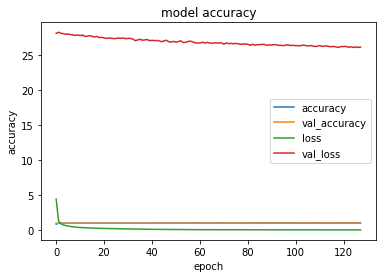

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [16]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [17]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [18]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [19]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-15 11:26:53,120 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 23ms/step


2020-12-15 11:26:57,009 [DEBUG] kashgari - predict output: (70, 17)
2020-12-15 11:26:57,010 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:26:57,014 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 38ms/step


2020-12-15 11:27:01,365 [DEBUG] kashgari - predict output: (131, 28)
2020-12-15 11:27:01,366 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:01,371 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 59ms/step


2020-12-15 11:27:06,096 [DEBUG] kashgari - predict output: (198, 47)
2020-12-15 11:27:06,097 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 11:27:06,099 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 37ms/step


2020-12-15 11:27:08,815 [DEBUG] kashgari - predict output: (96, 41)
2020-12-15 11:27:08,817 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:08,819 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 22ms/step


2020-12-15 11:27:08,947 [DEBUG] kashgari - predict output: (73, 17)
2020-12-15 11:27:08,948 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:08,954 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 40ms/step


2020-12-15 11:27:13,027 [DEBUG] kashgari - predict output: (266, 23)
2020-12-15 11:27:13,028 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 11:27:13,033 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 38ms/step


2020-12-15 11:27:17,158 [DEBUG] kashgari - predict output: (308, 21)
2020-12-15 11:27:17,159 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:17,163 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 45ms/step


2020-12-15 11:27:21,104 [DEBUG] kashgari - predict output: (139, 38)
2020-12-15 11:27:21,105 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:21,108 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 33ms/step


2020-12-15 11:27:25,535 [DEBUG] kashgari - predict output: (167, 22)
2020-12-15 11:27:25,536 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:25,541 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 0s 55ms/step


2020-12-15 11:27:30,034 [DEBUG] kashgari - predict output: (272, 41)
2020-12-15 11:27:30,036 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:30,042 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 71ms/step


2020-12-15 11:27:34,632 [DEBUG] kashgari - predict output: (143, 63)
2020-12-15 11:27:34,633 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:34,640 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 59ms/step


2020-12-15 11:27:39,620 [DEBUG] kashgari - predict output: (663, 42)
2020-12-15 11:27:39,621 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:39,623 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 16ms/step


2020-12-15 11:27:43,355 [DEBUG] kashgari - predict output: (39, 25)
2020-12-15 11:27:43,359 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 35ms/step


2020-12-15 11:27:43,646 [DEBUG] kashgari - predict output: (175, 22)
2020-12-15 11:27:43,647 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:43,651 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 37ms/step


2020-12-15 11:27:43,912 [DEBUG] kashgari - predict output: (143, 28)
2020-12-15 11:27:43,913 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:43,916 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 25ms/step


2020-12-15 11:27:44,054 [DEBUG] kashgari - predict output: (88, 21)
2020-12-15 11:27:44,055 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:44,058 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 33ms/step


2020-12-15 11:27:44,266 [DEBUG] kashgari - predict output: (121, 28)
2020-12-15 11:27:44,267 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:44,269 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 32ms/step


2020-12-15 11:27:48,747 [DEBUG] kashgari - predict output: (85, 27)
2020-12-15 11:27:48,748 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:48,753 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 36ms/step


2020-12-15 11:27:52,764 [DEBUG] kashgari - predict output: (255, 19)
2020-12-15 11:27:52,765 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:52,769 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 42ms/step


2020-12-15 11:27:56,885 [DEBUG] kashgari - predict output: (202, 29)
2020-12-15 11:27:56,886 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:56,889 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 33ms/step


2020-12-15 11:27:57,187 [DEBUG] kashgari - predict output: (198, 19)
2020-12-15 11:27:57,188 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 6 6 6]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:27:57,191 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 41ms/step


2020-12-15 11:28:01,147 [DEBUG] kashgari - predict output: (102, 39)
2020-12-15 11:28:01,148 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:01,150 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 33ms/step


2020-12-15 11:28:05,402 [DEBUG] kashgari - predict output: (72, 36)
2020-12-15 11:28:05,403 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:05,408 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 44ms/step


2020-12-15 11:28:05,842 [DEBUG] kashgari - predict output: (246, 27)
2020-12-15 11:28:05,843 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:05,846 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 27ms/step


2020-12-15 11:28:09,725 [DEBUG] kashgari - predict output: (57, 34)
2020-12-15 11:28:09,726 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:09,728 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 27ms/step


2020-12-15 11:28:09,883 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 11:28:09,884 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:09,889 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 46ms/step


2020-12-15 11:28:13,920 [DEBUG] kashgari - predict output: (185, 32)
2020-12-15 11:28:13,921 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:13,925 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 39ms/step


2020-12-15 11:28:14,203 [DEBUG] kashgari - predict output: (148, 28)
2020-12-15 11:28:14,204 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:14,207 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 37ms/step


2020-12-15 11:28:14,617 [DEBUG] kashgari - predict output: (281, 23)
2020-12-15 11:28:14,618 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:14,621 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 29ms/step


2020-12-15 11:28:19,768 [DEBUG] kashgari - predict output: (116, 20)
2020-12-15 11:28:19,769 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:19,773 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 38ms/step


2020-12-15 11:28:20,079 [DEBUG] kashgari - predict output: (168, 25)
2020-12-15 11:28:20,080 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:20,085 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 44ms/step


2020-12-15 11:28:24,172 [DEBUG] kashgari - predict output: (218, 30)
2020-12-15 11:28:24,173 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:24,175 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 38ms/step


2020-12-15 11:28:24,407 [DEBUG] kashgari - predict output: (123, 32)
2020-12-15 11:28:24,408 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:24,411 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 25ms/step


2020-12-15 11:28:24,554 [DEBUG] kashgari - predict output: (82, 21)
2020-12-15 11:28:24,555 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:24,559 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-15 11:28:24,703 [DEBUG] kashgari - predict output: (95, 19)
2020-12-15 11:28:24,704 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:24,710 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 40ms/step


2020-12-15 11:28:28,841 [DEBUG] kashgari - predict output: (245, 24)
2020-12-15 11:28:28,842 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:28,845 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 40ms/step


2020-12-15 11:28:32,854 [DEBUG] kashgari - predict output: (126, 31)
2020-12-15 11:28:32,855 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:32,857 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 16ms/step


2020-12-15 11:28:35,511 [DEBUG] kashgari - predict output: (64, 19)
2020-12-15 11:28:35,512 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:35,515 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 31ms/step


2020-12-15 11:28:35,684 [DEBUG] kashgari - predict output: (93, 24)
2020-12-15 11:28:35,686 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:35,690 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 30ms/step


2020-12-15 11:28:39,636 [DEBUG] kashgari - predict output: (214, 16)
2020-12-15 11:28:39,637 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:39,639 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-15 11:28:39,743 [DEBUG] kashgari - predict output: (53, 20)
2020-12-15 11:28:39,744 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:39,751 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 27ms/step


2020-12-15 11:28:43,035 [DEBUG] kashgari - predict output: (384, 18)
2020-12-15 11:28:43,036 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:43,040 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 35ms/step


2020-12-15 11:28:43,319 [DEBUG] kashgari - predict output: (172, 24)
2020-12-15 11:28:43,320 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:43,323 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 30ms/step


2020-12-15 11:28:43,517 [DEBUG] kashgari - predict output: (114, 24)
2020-12-15 11:28:43,518 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:43,522 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 51ms/step


2020-12-15 11:28:43,822 [DEBUG] kashgari - predict output: (111, 47)
2020-12-15 11:28:43,823 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:43,830 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 47ms/step


2020-12-15 11:28:44,437 [DEBUG] kashgari - predict output: (350, 34)
2020-12-15 11:28:44,438 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:44,440 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-15 11:28:44,541 [DEBUG] kashgari - predict output: (56, 20)
2020-12-15 11:28:44,542 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:44,545 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 27ms/step


2020-12-15 11:28:44,748 [DEBUG] kashgari - predict output: (131, 17)
2020-12-15 11:28:44,750 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:44,754 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 43ms/step


2020-12-15 11:28:45,089 [DEBUG] kashgari - predict output: (184, 34)
2020-12-15 11:28:45,090 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:45,093 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 53ms/step


2020-12-15 11:28:49,248 [DEBUG] kashgari - predict output: (133, 51)
2020-12-15 11:28:49,250 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:49,253 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 65ms/step


2020-12-15 11:28:53,509 [DEBUG] kashgari - predict output: (210, 53)
2020-12-15 11:28:53,510 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:53,513 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 64ms/step


2020-12-15 11:28:58,825 [DEBUG] kashgari - predict output: (193, 55)
2020-12-15 11:28:58,826 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:58,829 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 29ms/step


2020-12-15 11:28:58,987 [DEBUG] kashgari - predict output: (75, 30)
2020-12-15 11:28:58,987 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:28:58,993 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 63ms/step


2020-12-15 11:29:03,315 [DEBUG] kashgari - predict output: (280, 46)
2020-12-15 11:29:03,316 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:03,319 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 33ms/step


2020-12-15 11:29:03,619 [DEBUG] kashgari - predict output: (210, 20)
2020-12-15 11:29:03,620 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:03,624 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 36ms/step


2020-12-15 11:29:03,909 [DEBUG] kashgari - predict output: (176, 24)
2020-12-15 11:29:03,910 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:03,914 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 38ms/step


2020-12-15 11:29:04,251 [DEBUG] kashgari - predict output: (218, 25)
2020-12-15 11:29:04,252 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:04,254 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 28ms/step


2020-12-15 11:29:04,406 [DEBUG] kashgari - predict output: (91, 23)
2020-12-15 11:29:04,407 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:04,412 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 37ms/step


2020-12-15 11:29:04,748 [DEBUG] kashgari - predict output: (194, 28)
2020-12-15 11:29:04,749 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:04,753 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 35ms/step


2020-12-15 11:29:05,039 [DEBUG] kashgari - predict output: (179, 23)
2020-12-15 11:29:05,040 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:05,044 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 52ms/step


2020-12-15 11:29:09,226 [DEBUG] kashgari - predict output: (234, 40)
2020-12-15 11:29:09,227 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:09,231 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 40ms/step


2020-12-15 11:29:13,322 [DEBUG] kashgari - predict output: (250, 26)
2020-12-15 11:29:13,323 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:13,326 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 50ms/step


2020-12-15 11:29:17,405 [DEBUG] kashgari - predict output: (170, 43)
2020-12-15 11:29:17,406 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:17,409 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 39ms/step


2020-12-15 11:29:17,682 [DEBUG] kashgari - predict output: (145, 34)
2020-12-15 11:29:17,683 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:17,686 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 31ms/step


2020-12-15 11:29:17,885 [DEBUG] kashgari - predict output: (102, 29)
2020-12-15 11:29:17,886 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:17,893 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 34ms/step


2020-12-15 11:29:18,340 [DEBUG] kashgari - predict output: (340, 20)
2020-12-15 11:29:18,341 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:18,343 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 32ms/step


2020-12-15 11:29:18,546 [DEBUG] kashgari - predict output: (122, 23)
2020-12-15 11:29:18,547 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:18,554 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 1s 43ms/step


2020-12-15 11:29:19,150 [DEBUG] kashgari - predict output: (381, 28)
2020-12-15 11:29:19,151 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:19,154 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 40ms/step


2020-12-15 11:29:19,553 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 11:29:19,554 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:19,558 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 45ms/step


2020-12-15 11:29:19,789 [DEBUG] kashgari - predict output: (91, 46)
2020-12-15 11:29:19,790 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:19,794 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 53ms/step


2020-12-15 11:29:20,259 [DEBUG] kashgari - predict output: (223, 42)
2020-12-15 11:29:20,260 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:20,263 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 34ms/step


2020-12-15 11:29:20,502 [DEBUG] kashgari - predict output: (146, 25)
2020-12-15 11:29:20,503 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:20,507 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 34ms/step


2020-12-15 11:29:20,781 [DEBUG] kashgari - predict output: (162, 23)
2020-12-15 11:29:20,782 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:20,788 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 40ms/step


2020-12-15 11:29:21,182 [DEBUG] kashgari - predict output: (244, 27)
2020-12-15 11:29:21,183 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:21,187 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 30ms/step


2020-12-15 11:29:25,317 [DEBUG] kashgari - predict output: (170, 18)
2020-12-15 11:29:25,318 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:25,322 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 45ms/step


2020-12-15 11:29:25,730 [DEBUG] kashgari - predict output: (199, 36)
2020-12-15 11:29:25,731 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:25,739 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 34ms/step


2020-12-15 11:29:26,421 [DEBUG] kashgari - predict output: (557, 17)
2020-12-15 11:29:26,422 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 9 5 ... 5 5 5]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:26,426 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 54ms/step


2020-12-15 11:29:27,010 [DEBUG] kashgari - predict output: (278, 42)
2020-12-15 11:29:27,011 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:27,014 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 25ms/step


2020-12-15 11:29:27,153 [DEBUG] kashgari - predict output: (91, 19)
2020-12-15 11:29:27,154 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:27,159 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 38ms/step


2020-12-15 11:29:27,605 [DEBUG] kashgari - predict output: (296, 24)
2020-12-15 11:29:27,606 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:27,609 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 58ms/step


2020-12-15 11:29:31,690 [DEBUG] kashgari - predict output: (154, 48)
2020-12-15 11:29:31,691 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:31,694 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 49ms/step


2020-12-15 11:29:35,930 [DEBUG] kashgari - predict output: (206, 37)
2020-12-15 11:29:35,931 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:35,934 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 32ms/step


2020-12-15 11:29:36,259 [DEBUG] kashgari - predict output: (241, 20)
2020-12-15 11:29:36,260 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 3 2 ... 2 2 2]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:36,266 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 47ms/step


2020-12-15 11:29:37,050 [DEBUG] kashgari - predict output: (459, 31)
2020-12-15 11:29:37,051 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:37,055 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 46ms/step


2020-12-15 11:29:37,458 [DEBUG] kashgari - predict output: (223, 34)
2020-12-15 11:29:37,459 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:37,465 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 0s 40ms/step


2020-12-15 11:29:38,020 [DEBUG] kashgari - predict output: (358, 26)
2020-12-15 11:29:38,021 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:38,023 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 24ms/step


2020-12-15 11:29:38,158 [DEBUG] kashgari - predict output: (72, 20)
2020-12-15 11:29:38,159 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:38,161 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 26ms/step


2020-12-15 11:29:38,306 [DEBUG] kashgari - predict output: (75, 24)
2020-12-15 11:29:38,307 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:38,312 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 47ms/step


2020-12-15 11:29:38,676 [DEBUG] kashgari - predict output: (191, 36)
2020-12-15 11:29:38,677 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:38,681 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 30ms/step


2020-12-15 11:29:38,892 [DEBUG] kashgari - predict output: (149, 19)
2020-12-15 11:29:38,893 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:38,896 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 32ms/step


2020-12-15 11:29:39,153 [DEBUG] kashgari - predict output: (176, 22)
2020-12-15 11:29:39,154 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:39,158 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 55ms/step


2020-12-15 11:29:43,430 [DEBUG] kashgari - predict output: (112, 45)
2020-12-15 11:29:43,431 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:43,435 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 34ms/step


2020-12-15 11:29:43,810 [DEBUG] kashgari - predict output: (269, 21)
2020-12-15 11:29:43,810 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:43,813 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 27ms/step


2020-12-15 11:29:43,985 [DEBUG] kashgari - predict output: (112, 18)
2020-12-15 11:29:43,986 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 7 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:43,992 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 29ms/step


2020-12-15 11:29:47,405 [DEBUG] kashgari - predict output: (352, 22)
2020-12-15 11:29:47,405 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:47,409 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 37ms/step


2020-12-15 11:29:47,778 [DEBUG] kashgari - predict output: (243, 24)
2020-12-15 11:29:47,779 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:47,783 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 40ms/step


2020-12-15 11:29:48,306 [DEBUG] kashgari - predict output: (340, 27)
2020-12-15 11:29:48,307 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:48,314 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 33ms/step


2020-12-15 11:29:51,373 [DEBUG] kashgari - predict output: (384, 25)
2020-12-15 11:29:51,373 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:51,376 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 38ms/step


2020-12-15 11:29:51,611 [DEBUG] kashgari - predict output: (112, 36)
2020-12-15 11:29:51,612 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:51,616 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 39ms/step


2020-12-15 11:29:51,963 [DEBUG] kashgari - predict output: (222, 28)
2020-12-15 11:29:51,964 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:51,967 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 46ms/step


2020-12-15 11:29:52,416 [DEBUG] kashgari - predict output: (255, 34)
2020-12-15 11:29:52,417 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:52,419 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 26ms/step


2020-12-15 11:29:52,567 [DEBUG] kashgari - predict output: (67, 25)
2020-12-15 11:29:52,568 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:52,571 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 40ms/step


2020-12-15 11:29:52,790 [DEBUG] kashgari - predict output: (77, 53)
2020-12-15 11:29:52,791 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:52,793 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 26ms/step


2020-12-15 11:29:52,940 [DEBUG] kashgari - predict output: (67, 27)
2020-12-15 11:29:52,941 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:52,944 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 24ms/step


2020-12-15 11:29:53,083 [DEBUG] kashgari - predict output: (72, 19)
2020-12-15 11:29:53,084 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:53,088 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 29ms/step


2020-12-15 11:29:53,272 [DEBUG] kashgari - predict output: (98, 24)
2020-12-15 11:29:53,273 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:53,276 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 37ms/step


2020-12-15 11:29:53,472 [DEBUG] kashgari - predict output: (87, 37)
2020-12-15 11:29:53,473 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:53,480 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 44ms/step


2020-12-15 11:29:53,997 [DEBUG] kashgari - predict output: (311, 29)
2020-12-15 11:29:53,998 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:54,010 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 1s 36ms/step


2020-12-15 11:29:54,579 [DEBUG] kashgari - predict output: (447, 20)
2020-12-15 11:29:54,580 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:54,584 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 32ms/step


2020-12-15 11:29:54,875 [DEBUG] kashgari - predict output: (218, 19)
2020-12-15 11:29:54,876 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:54,880 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 42ms/step


2020-12-15 11:29:55,333 [DEBUG] kashgari - predict output: (285, 30)
2020-12-15 11:29:55,334 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:55,338 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 1s 36ms/step


2020-12-15 11:29:55,910 [DEBUG] kashgari - predict output: (424, 21)
2020-12-15 11:29:55,911 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:55,913 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 33ms/step


2020-12-15 11:29:56,086 [DEBUG] kashgari - predict output: (94, 30)
2020-12-15 11:29:56,087 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:56,091 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 43ms/step


2020-12-15 11:29:56,466 [DEBUG] kashgari - predict output: (202, 34)
2020-12-15 11:29:56,467 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:29:56,471 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 0s 59ms/step


2020-12-15 11:30:02,048 [DEBUG] kashgari - predict output: (242, 50)
2020-12-15 11:30:02,049 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-15 11:30:02,053 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 46ms/step


2020-12-15 11:30:02,550 [DEBUG] kashgari - predict output: (269, 38)
2020-12-15 11:30:02,551 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:02,553 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 39ms/step


2020-12-15 11:30:06,513 [DEBUG] kashgari - predict output: (108, 35)
2020-12-15 11:30:06,514 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:06,517 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 37ms/step


2020-12-15 11:30:06,775 [DEBUG] kashgari - predict output: (136, 30)
2020-12-15 11:30:06,777 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:06,781 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 37ms/step


2020-12-15 11:30:07,112 [DEBUG] kashgari - predict output: (217, 28)
2020-12-15 11:30:07,113 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:07,115 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 27ms/step


2020-12-15 11:30:07,263 [DEBUG] kashgari - predict output: (83, 27)
2020-12-15 11:30:07,264 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:07,270 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 49ms/step


2020-12-15 11:30:07,996 [DEBUG] kashgari - predict output: (392, 36)
2020-12-15 11:30:07,998 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:08,002 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 42ms/step


2020-12-15 11:30:08,258 [DEBUG] kashgari - predict output: (108, 41)
2020-12-15 11:30:08,259 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:08,264 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 39ms/step


2020-12-15 11:30:08,604 [DEBUG] kashgari - predict output: (221, 26)
2020-12-15 11:30:08,605 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:08,608 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 43ms/step


2020-12-15 11:30:08,832 [DEBUG] kashgari - predict output: (94, 45)
2020-12-15 11:30:08,833 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:08,835 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 19ms/step


2020-12-15 11:30:08,933 [DEBUG] kashgari - predict output: (59, 21)
2020-12-15 11:30:08,934 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:08,937 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 38ms/step


2020-12-15 11:30:13,268 [DEBUG] kashgari - predict output: (101, 33)
2020-12-15 11:30:13,269 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:13,271 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 22ms/step


2020-12-15 11:30:15,935 [DEBUG] kashgari - predict output: (64, 33)
2020-12-15 11:30:15,936 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:15,939 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 32ms/step


2020-12-15 11:30:16,109 [DEBUG] kashgari - predict output: (85, 30)
2020-12-15 11:30:16,110 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:16,113 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 34ms/step


2020-12-15 11:30:16,301 [DEBUG] kashgari - predict output: (89, 33)
2020-12-15 11:30:16,302 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:16,306 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 42ms/step


2020-12-15 11:30:16,726 [DEBUG] kashgari - predict output: (254, 27)
2020-12-15 11:30:16,727 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:16,730 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 35ms/step


2020-12-15 11:30:16,983 [DEBUG] kashgari - predict output: (129, 29)
2020-12-15 11:30:16,983 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:16,987 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 33ms/step


2020-12-15 11:30:17,225 [DEBUG] kashgari - predict output: (130, 26)
2020-12-15 11:30:17,226 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:17,230 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 43ms/step


2020-12-15 11:30:17,526 [DEBUG] kashgari - predict output: (143, 37)
2020-12-15 11:30:17,527 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:17,530 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 38ms/step


2020-12-15 11:30:17,764 [DEBUG] kashgari - predict output: (107, 36)
2020-12-15 11:30:17,765 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:17,767 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 27ms/step


2020-12-15 11:30:17,921 [DEBUG] kashgari - predict output: (70, 28)
2020-12-15 11:30:17,922 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:17,926 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 38ms/step


2020-12-15 11:30:18,231 [DEBUG] kashgari - predict output: (189, 26)
2020-12-15 11:30:18,232 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:18,235 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 46ms/step


2020-12-15 11:30:18,517 [DEBUG] kashgari - predict output: (99, 48)
2020-12-15 11:30:18,518 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:18,522 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 45ms/step


2020-12-15 11:30:18,925 [DEBUG] kashgari - predict output: (213, 35)
2020-12-15 11:30:18,926 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:18,930 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 49ms/step


2020-12-15 11:30:19,315 [DEBUG] kashgari - predict output: (181, 40)
2020-12-15 11:30:19,316 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:19,319 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 39ms/step


2020-12-15 11:30:19,551 [DEBUG] kashgari - predict output: (119, 34)
2020-12-15 11:30:19,552 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:19,557 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 69ms/step


2020-12-15 11:30:24,035 [DEBUG] kashgari - predict output: (188, 52)
2020-12-15 11:30:24,036 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:24,040 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 43ms/step


2020-12-15 11:30:24,473 [DEBUG] kashgari - predict output: (252, 30)
2020-12-15 11:30:24,474 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:24,477 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 53ms/step


2020-12-15 11:30:25,002 [DEBUG] kashgari - predict output: (249, 38)
2020-12-15 11:30:25,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:25,005 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 39ms/step


2020-12-15 11:30:29,237 [DEBUG] kashgari - predict output: (65, 44)
2020-12-15 11:30:29,238 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-15 11:30:29,243 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 1s 58ms/step


2020-12-15 11:30:29,866 [DEBUG] kashgari - predict output: (265, 41)
2020-12-15 11:30:29,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:29,871 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 43ms/step


2020-12-15 11:30:30,222 [DEBUG] kashgari - predict output: (163, 33)
2020-12-15 11:30:30,223 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:30,228 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 45ms/step


2020-12-15 11:30:30,580 [DEBUG] kashgari - predict output: (166, 33)
2020-12-15 11:30:30,581 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 7 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:30,585 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 48ms/step


2020-12-15 11:30:30,917 [DEBUG] kashgari - predict output: (152, 37)
2020-12-15 11:30:30,918 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:30,921 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 37ms/step


2020-12-15 11:30:31,179 [DEBUG] kashgari - predict output: (129, 26)
2020-12-15 11:30:31,180 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:31,183 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 55ms/step


2020-12-15 11:30:31,777 [DEBUG] kashgari - predict output: (260, 42)
2020-12-15 11:30:31,778 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:31,786 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 81ms/step


2020-12-15 11:30:37,387 [DEBUG] kashgari - predict output: (557, 59)
2020-12-15 11:30:37,388 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:37,392 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 81ms/step


2020-12-15 11:30:41,938 [DEBUG] kashgari - predict output: (144, 72)
2020-12-15 11:30:41,939 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:41,946 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 45ms/step


2020-12-15 11:30:42,706 [DEBUG] kashgari - predict output: (474, 27)
2020-12-15 11:30:42,707 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:42,711 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 48ms/step


2020-12-15 11:30:43,188 [DEBUG] kashgari - predict output: (253, 34)
2020-12-15 11:30:43,189 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:43,192 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 59ms/step


2020-12-15 11:30:43,715 [DEBUG] kashgari - predict output: (210, 45)
2020-12-15 11:30:43,716 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:43,720 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 46ms/step


2020-12-15 11:30:44,170 [DEBUG] kashgari - predict output: (244, 32)
2020-12-15 11:30:44,171 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:44,179 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 1s 53ms/step


2020-12-15 11:30:44,811 [DEBUG] kashgari - predict output: (319, 36)
2020-12-15 11:30:44,812 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:44,820 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 54ms/step


2020-12-15 11:30:45,659 [DEBUG] kashgari - predict output: (437, 36)
2020-12-15 11:30:45,660 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-15 11:30:45,664 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 1s 91ms/step


2020-12-15 11:30:50,672 [DEBUG] kashgari - predict output: (171, 78)
2020-12-15 11:30:50,673 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [20]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [21]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,113,115,今天,time
1,0,227,229,麻豆,location
2,0,237,239,麻豆,location
3,1,31,33,今天,time
4,1,76,80,0.79,med_exam
...,...,...,...,...,...
2710,158,193,197,四個禮拜,time
2711,158,448,450,二十,med_exam
2712,158,1143,1145,今天,time
2713,158,1199,1201,小安,name
